# DeerLab Workshop 2023
## EFEPR Summer School
## Hugo Karas

Based on the work by Luis Fábregas Ibáñez

## What is DeerLab?

DeerLab is an advanced python based software for analysing DEER/PELDOR data using Tikihnov regularisation

## Getting Started

First we will look at processing a simple 4-pulse DEER trace

In [2]:
import deerlab as dl
# We all need some other packages too
import numpy as np # Numerical calculations and array handling
import matplotlib.pyplot as plt # Plotting

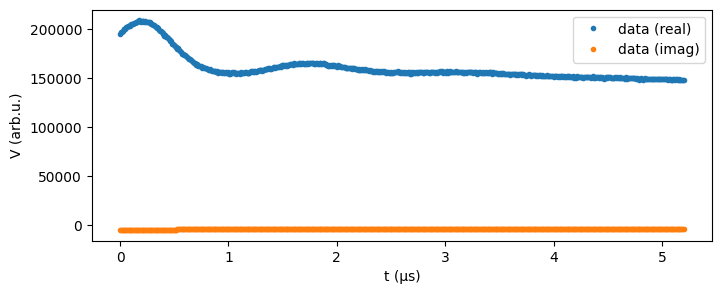

In [3]:
t,V = dl.deerload('../data/example_4pdeer_4.DTA')

# Plot the data
plt.figure(figsize=(8,3))
plt.plot(t,V.real,'.',label='data (real)')
plt.plot(t,V.imag,'.',label='data (imag)')
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.legend()
plt.show()

## Pre-processing Data

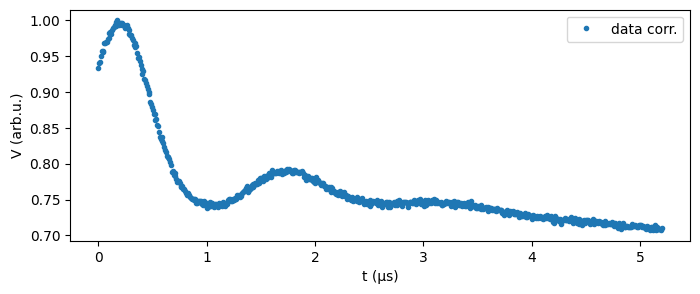

In [4]:
# Phase correction
Vexp = dl.correctphase(V)
# Normalize the data (only for plotting purposes)
Vexp = Vexp/np.max(Vexp)
plt.figure(figsize=(8,3))
plt.plot(t,Vexp,'.',label='data corr.')
plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.legend()
plt.show()

### Acounting for the start time

Since DeerLab has been designed for multi-pathway data, the definition of the zero point in time is critically important

<img style="width:500px; alignment:center" src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/main/images/4pdeer_sequence_starttime.svg">

In Deerlab the *zerotime* is defined as the time of $\pi$ pulse before the moving pump pulse


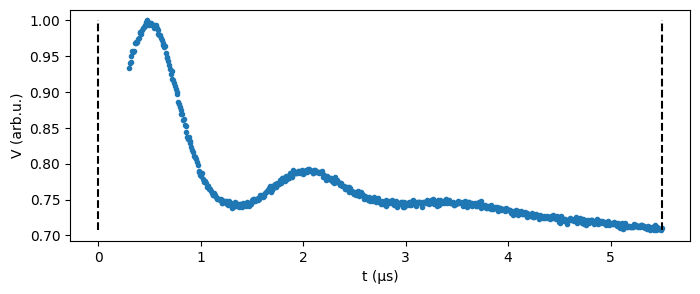

In [17]:
tau1 = 0.5 # µs
tau2 = 5.0 # µs
deadtime = 0.3 # µs

t = t -t[0]
t = t + deadtime

plt.figure(figsize=(8,3))
plt.plot(t,Vexp,'.',label='data corr.')

plt.vlines(0,min(Vexp),max(Vexp),'k',linestyle='dashed')
plt.vlines(tau1+tau2,min(Vexp),max(Vexp),'k',linestyle='dashed')

plt.xlabel('t (µs)')
plt.ylabel('V (arb.u.)')
plt.show()

## Fitting

Before we can fit out data we must first build a model.

We can build a simple dipolar model

In [6]:
# Define the distance range
r = np.linspace(2,5,50) # range from 2.2-5.2nm with 0.02nm resolution

# Construct the dipolar model
Vmodel = dl.dipolarmodel(t,r) 

# Display information about the dipolar model
print(Vmodel)

Description: Dipolar signal model
Signature: (mod, reftime, conc, P)
Constants: []
Parameter Table: 
========= ======= ======= ======= ======== ======== ====== ====================================== 
 Name      Lower   Start   Upper    Type    Frozen   Unit   Description                           
========= ======= ======= ======= ======== ======== ====== ====================================== 
 mod           0    0.01       1   nonlin     No            Modulation depth                      
 reftime     -20       0      20   nonlin     No      μs    Refocusing time                       
 conc       0.01      50   5e+03   nonlin     No      μM    Spin concentration                    
 P             0       0     inf   linear     No     nm⁻¹   Non-parametric distance distribution  
========= ======= ======= ======= ======== ======== ====== ====================================== 


DeerLab includes a wide range of built in models which can then handle the different pathways.

- 4pDEER
- fwd5pDEER
- rev5pDEER
- RIDME

and many more...

In [7]:
# Construct model of our 4-pulse DEER experiment
my4pdeer = dl.ex_4pdeer(tau1,tau2,pathways=[1,2,3])

# Construct the dipolar signal model including experimental information
Vmodel = dl.dipolarmodel(t,r, experiment=my4pdeer) 

# Display information about the model
print(Vmodel)

Description: 4-pulse DEER dipolar signal model
Signature: (lam1, reftime1, lam2, reftime2, lam3, reftime3, conc, P)
Constants: []
Parameter Table: 
========== ======== ======= ======= ======== ======== ====== ====================================== 
 Name       Lower    Start   Upper    Type    Frozen   Unit   Description                           
========== ======== ======= ======= ======== ======== ====== ====================================== 
 lam1           0     0.01       1   nonlin     No            Amplitude of pathway #1               
 reftime1   0.452      0.5   0.548   nonlin     No      μs    Refocusing time of pathway #1         
 lam2           0     0.01       1   nonlin     No            Amplitude of pathway #2               
 reftime2    5.45      5.5    5.55   nonlin     No      μs    Refocusing time of pathway #2         
 lam3           0     0.01       1   nonlin     No            Amplitude of pathway #3               
 reftime3   -0.048       0   0.048   nonlin 

We can now use this model to fit our data in one go

In [8]:
results = dl.fit(Vmodel,Vexp,verbose=2,  ftol=1e-3,)

[26-7-2023 10:10:1] Preparing the SNLLS analysis...
[26-7-2023 10:10:1] Preparations completed.
[26-7-2023 10:10:1] Non-linear least-squares routine in progress...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4318e+00                                    1.06e+01    
       1              3         8.4006e-01      5.92e-01       2.40e+02       1.04e+01    
       2              4         9.1607e-02      7.48e-01       3.61e+01       3.83e-01    
       3              5         5.0215e-02      4.14e-02       5.45e+01       4.71e-01    
       4              6         1.2057e-02      3.82e-02       8.82e+01       2.00e+00    
       5              7         4.2214e-03      7.84e-03       4.71e+00       1.98e-01    
       6              8         2.2991e-03      1.92e-03       7.97e-01       2.09e-03    
       7              9         1.7978e-03      5.01e-04       3.77e+00       3.82e-02    
       8         

In [9]:
print(results)

Goodness-of-fit: 
========= ============= ============= ===================== ======= 
 Dataset   Noise level   Reduced 𝛘2    Residual autocorr.    RMSD   
========= ============= ============= ===================== ======= 
   #1         0.002         0.979             0.032          0.002  
========= ============= ============= ===================== ======= 
Model hyperparameters: 
 Regularization parameter  
          0.011            
Model parameters: 
=========== ========== ========================= ====== ====================================== 
 Parameter   Value      95%-Confidence interval   Unit   Description                           
=========== ========== ========================= ====== ====================================== 
 lam1        0.199      (0.167,0.232)                    Amplitude of pathway #1               
 reftime1    0.498      (0.455,0.541)              μs    Refocusing time of pathway #1         
 lam2        0.005      (0.003,0.008)                    A

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

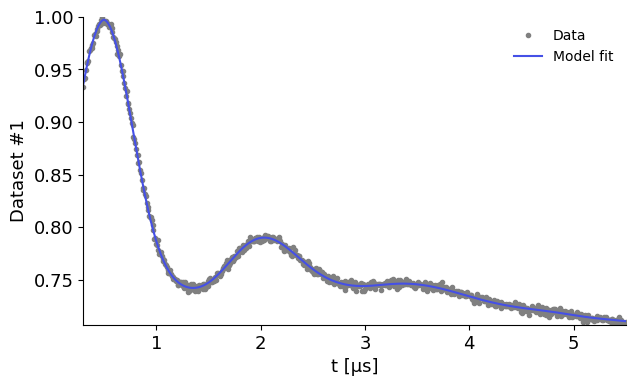

In [10]:
results.plot(axis=t,xlabel='t [μs]')

# Show the plot
plt.show() 

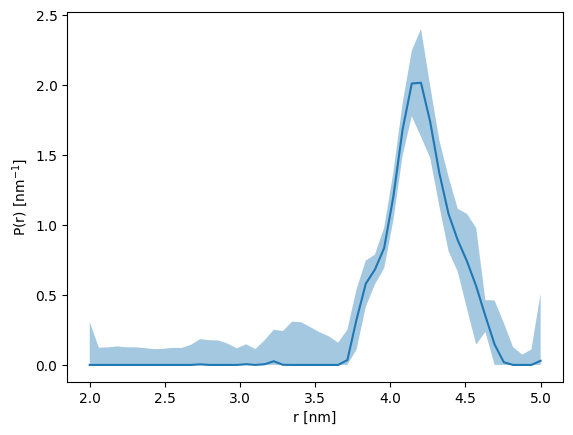

In [11]:
# Get the fitted distance distribution
Pfit = results.P
# Get the uncertainty quantification of the distance distribution
Puq = results.PUncert
# Get its 95% confidence intervals
Pci95 = Puq.ci(95)

# Get the lower/upper boundaries of the confidence intervals
Pci95_lower = Pci95[:,0]
Pci95_upper = Pci95[:,1]

# Plot the fitted distance distribution
plt.plot(r,Pfit)
# Plot the confidence bands as a filled area
plt.fill_between(r,Pci95_lower,Pci95_upper,alpha=0.4)
plt.xlabel('r [nm]')
plt.ylabel('P(r) [nm$^{-1}$]')
plt.show()

In [12]:
mod_fit = results.lam1 + results.lam2 + results.lam3
mod_ci95 = results.lam1Uncert.ci(95) + results.lam2Uncert.ci(95) + results.lam3Uncert.ci(95)

# Spin concentration
conc_fit = results.conc
conc_ci95 = results.concUncert.ci(95)


print(f'Modulation depth: {mod_fit:.3f} ({mod_ci95[0]:.3f},{mod_ci95[1]:.3f})')
print(f'Spin concentration: {conc_fit:.4g}uM ({conc_ci95[0]:.4g},{conc_ci95[1]:.4g})')

Modulation depth: 0.204 (0.169,0.260)
Spin concentration: 124.1uM (95.91,152.2)


In [13]:
stats = dl.diststats(r,Pfit,Puq,verbose=True)

-------------------------------------------------
Distribution Statistics
-------------------------------------------------
Range                    2.00-5.00 nm
Integral                 1.00
-------------------------------------------------
Location
-------------------------------------------------
Range                    2.00-5.00 nm
Mean                     4.20 (4.19,4.21) nm
Median                   4.20 (4.19,4.20) nm
Interquartile mean       4.20 (4.20,4.20) nm
Mode                     4.20 nm
-------------------------------------------------
Spread
-------------------------------------------------
Standard deviation       0.22 (0.12,0.31) nm
Mean absolute deviation  0.17 (0.16,0.18) nm
Interquartile range      0.28 (0.27,0.30) nm
Variance                 0.05 (0.01,0.09) nm²
-------------------------------------------------
Shape
-------------------------------------------------
Modality                 1
Skewness                 -0.15 (-8.57,8.27) 
Kurtosis                 -1

## Getting Help

Detailed documentation can be found at: jeschkelab.github.io/DeerLab

Including Examples:


### Asking Others
Post questions and queries on the discuisson board: 

### Reporting Issues:
Help the development team buy requesting new features and reporting bugs on GitHub. We can't fix an issue or implement a new feature if we don't know it exists.

## Advanced Techniques

- Custom Dipolar Modelling
- Compactness Criterion
- Global Fitting

## Custom Dipolar Modeling

## Compactness Criterion


It is often the case that there is a non-unique solution for the speration of the background. This is especially tue for noisy data and dataset where the trace is not long enough.

<img src="https://raw.githubusercontent.com/JeschkeLab/DeerLabWorkshop2022/2746d801bdf97b7afd75d4f666d8fd414af490d8/images/example_identiability.svg" style="width:700px">

DeerLab has a compactness penalty introduced in the regularization. This has the effect of adding an aditional penalty to the objective function than penalizes non-compact data. 

For nearly all applications it is recomended that the compactness criterion is used.

In [ ]:
compactness = dl.dipolarpenalty(Pmodel=None, r=r, type='compactness')
results = dl.fit(Vmodel,Vexp,penalties=compactness)
print(results)

## Global Fitting